In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import shapely as shp
from datetime import datetime

from itertools import compress

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

In [2]:
# read in nyc census block shapefiles
nycshp = gp.read_file('data/nycb2010_16c/nycb2010.shp')

# set up cooridnate system
nycshp = nycshp.to_crs(epsg=4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

# we only need manhattan 
manshp = nycshp[nycshp.BoroName == 'Manhattan']

# add state code 36 and leading digits for county code 06
manshp['BCTCB2010'] = '3606' + manshp['BCTCB2010']

# keep only what we need
manshp = manshp[['BCTCB2010','geometry']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# read in 2014 citibike data
citi = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('citibike' in i) for i in os.listdir('data')])):
    citinew = pd.read_csv('data/'+m)
    citi = citi.append(citinew, ignore_index = True)
#citi = pd.read_csv('data/citibike_201406.csv')

In [4]:
# keep only stations available all year
jan = pd.read_csv('data/citibike_201401.csv')
orig_stations = jan['start station id'].unique()

citi = citi[np.in1d(citi['start station id'], orig_stations)]

In [5]:
# keep only subscribers
citi = citi[citi['usertype'] == 'Subscriber']

In [6]:
#Convert starttime to timpstamp format
citi['timestamp'] = pd.to_datetime(citi["starttime"])

#Pull day of week from timstamp (Mon, Tues etc)
citi['dow'] = citi['timestamp'].dt.dayofweek 

#Only keep weekdays
citi = citi[citi['dow'] <= 4]

In [7]:
#Keep only commute hours
citi.index = citi.timestamp
citi_morning = citi.between_time('7:00:00','10:00:00', include_start=True, include_end=True)
citi_morning = citi_morning.reset_index(drop = True)
citi_evening = citi.between_time('16:00:00','19:00:00', include_start=True, include_end=True)
citi_evening = citi_evening.reset_index(drop = True)

citi = citi_morning.append(citi_evening, ignore_index = True)

In [8]:
# dataframe for stations    
citi_docks = citi[['start station id','start station name','start station latitude','start station longitude']]
citi_docks.columns = ['station_id','name','lat','lon']
citi_docks.drop_duplicates(inplace = True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [9]:
# even after dropping duplicates there are some duplicated station ids. Drop them.
dups = citi_docks[citi_docks.station_id.duplicated(keep = False)].station_id.unique()
citi_docks = citi_docks[[i not in dups for i in citi_docks.station_id]]

In [10]:
# dataframe for rides per station
citi_rides = citi[['start station id', 'tripduration']] # keep duration because we need a column to count with
citi_rides.columns = ['station_id','n_rides']
citi_rides = citi_rides.groupby('station_id').count()

In [11]:
# merge number of rides into station detail table
citi_docks = citi_docks.merge(citi_rides, how = 'left', left_on = 'station_id', right_index = True)

In [12]:
# combine lat and lon to one column
citi_docks['lonlat']=zip(citi_docks.lon, citi_docks.lat)
# Create Point Geometry for based on lonlat column
citi_docks['geometry']=citi_docks[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
citi_docks = citi_docks[['station_id', 'n_rides', 'geometry']]
citi_docks.head()

,station_id,n_rides,geometry
0,302,5223,POINT (-73.97793172 40.72082834)
1,488,14647,POINT (-73.99372222 40.75645824)
2,502,8616,POINT (-73.981346 40.714215)
3,487,8969,POINT (-73.97573881 40.73314259)
5,128,14414,POINT (-74.00297088000001 40.72710258)


In [13]:
# buffer around each point

citi_docs = gp.GeoDataFrame(citi_docks, geometry = 'geometry')
citi_docs.crs = {'init' :'epsg:4326'}
citi_docs = citi_docs.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
manshp = manshp.to_crs(epsg=2263)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['compress', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


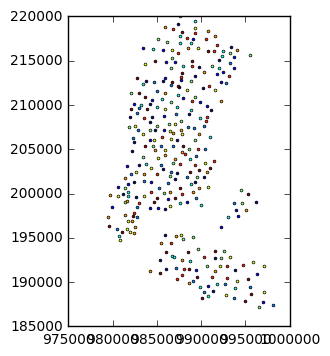

In [14]:
import pylab as pl
%pylab inline

citi_docs.plot()

In [15]:

manshp[manshp.geometry.intersects(citi_docs.iloc[50].geometry.buffer(150))]

,BCTCB2010,geometry
30620,360610087001000,"POLYGON ((986109.4495849601 209692.657849005, ..."
30621,360610058001009,"POLYGON ((987001.6940307618 209199.4242064266,..."
30675,360610087001001,"POLYGON ((985986.4846191395 209469.6488158047,..."
35478,360610054001000,"POLYGON ((986877.6326293944 208974.0506102334,..."


In [16]:
# check for each citibike stations to see what CB they belong to
a = []
citi_docs['tracts'] = 0
for i in range(len(citi_docks)):
    # includes stations not in Manhattan, return 0 for CB. 
    try: 
        a.append([k for k in manshp[manshp.geometry.intersects(citi_docs.iloc[i].geometry.buffer(150))].BCTCB2010])
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_docks))[:4],
citi_docs['tracts']=a
citi_docs = citi_docs.reindex()

% 100.


In [17]:

citi_docs.head()

,station_id,n_rides,geometry,tracts
0,302,5223,POINT (990367.1991470763 201894.5034764804),"[360610026011002, 360610020002004, 36061002000..."
1,488,14647,POINT (985989.2338921009 214874.8949317572),"[360610115001002, 360610115001003, 36061011500..."
2,502,8616,POINT (989421.2936561276 199484.8415778317),"[360610002021000, 360610002021002, 36061000202..."
3,487,8969,POINT (990973.8184738184 206381.12757902),"[360610060003002, 360610044002000, 36061006000..."
5,128,14414,POINT (983426.5668231647 204179.6463416842),"[360610037003001, 360610037002005, 36061004900..."


In [18]:
df = gp.read_file('data/cb_dist/cb_dist.shp')
df.cb = df.cb.astype('int')
demo = pd.read_csv('data/demo.csv')

In [19]:
df['geoid'] = [i[0:-3] for i in df.cb.astype('str')]
df = df.dissolve(by = 'geoid', aggfunc = 'mean', as_index = False)
df.head()

,geoid,geometry,cb,dist_tohom,dist_towor,workers
0,360610001001,"POLYGON ((972081.788024904 190733.467053102, 9...",3.606100e+14,6.260197,5.989905,7.0
1,360610002011,"POLYGON ((988376.7305908195 199328.6176268376,...",3.606100e+14,2.055703,2.408299,26.0
2,360610002012,"POLYGON ((988468.3774414052 198396.6901976364,...",3.606100e+14,2.783791,2.267989,28.0
3,360610002021,"POLYGON ((989558.0010375988 199244.3396117, 98...",3.606100e+14,3.254623,2.934503,53.5
4,360610002022,"POLYGON ((988892.5104370133 198246.2443968568,...",3.606100e+14,1.524783,2.292209,5.5


In [20]:
# get station demographics and distance
citi_demo = pd.DataFrame()
for i in range(len(citi_docs)):
    dists = transpose(pd.DataFrame(df[np.in1d(df.geoid, [j[0:-3] for j in citi_docs.tracts.iloc[i]])].mean()))
    dists.index = [citi_docs.station_id.iloc[i]]
    dems = transpose(pd.DataFrame(demo[np.in1d(demo.geoid.astype('str'), [j[0:-3] for j in citi_docs.tracts.iloc[i]])].mean()))
    dems.index = [citi_docs.station_id.iloc[i]]
    citi_new = dists.merge(dems, left_index = True, right_index = True)
    citi_demo = citi_demo.append(citi_new[['bike','commute_time','dist_tohom','dist_towor',\
                                           'income_pc','no_vehicle_own','no_vehicle_rent','pop','workers']])

In [21]:
citi_docs = citi_docs.merge(citi_demo, left_on = 'station_id', right_index = True)

In [22]:
# expore final data

if not os.path.exists('data/citi_docks/'):
    os.makedirs('data/citi_docks/')
    
citi_docs.drop('tracts',axis = 1, inplace = True)
citi_docs.to_file('data/citi_docks/citi_docks.shp')

citi_docs.head()
#citi_docs.to_csv('data/citi_docks.csv', index = False)

,station_id,n_rides,geometry,bike,commute_time,dist_tohom,dist_towor,income_pc,no_vehicle_own,no_vehicle_rent,pop,workers
0,302,5223,POINT (990367.1991470763 201894.5034764804),37.500000,751.750000,2.900031,2.009997,35375.000000,39.500000,510.500000,1561.000000,24.555556
1,488,14647,POINT (985989.2338921009 214874.8949317572),0.000000,636.500000,3.340853,1.241825,63984.000000,112.500000,342.500000,1043.000000,256.000000
2,502,8616,POINT (989421.2936561276 199484.8415778317),7.666667,407.000000,3.133704,2.381631,32061.666667,166.333333,112.000000,857.000000,31.166667
3,487,8969,POINT (990973.8184738184 206381.12757902),14.333333,840.666667,1.032838,1.624516,62840.000000,4.000000,584.333333,1745.333333,4.000000
5,128,14414,POINT (983426.5668231647 204179.6463416842),12.250000,647.500000,3.216434,1.936163,75221.250000,118.500000,465.750000,1062.000000,129.460417
